In [42]:
include("Particle.jl")
using LaTeXStrings

#-------- Particle(Position, Mass)
sun     = Particle([0, 0],     1)
earth   = Particle([0, 1],     3e-6)
jupiter = Particle([0, 5.36],  9.55e-4)
halley  = Particle([34.75, 0], 1e-14)

planets = [sun, earth, jupiter, halley]
planet_names = ["Sun", "Earth", "Jupiter", "Halley's comet"]   

# Verlet Setup
v0 = [[0,0], [-1, 0], [-0.425,0], [0,0.0296]]
x_old = [p.position for p in planets]
x_n = x_old .+ v0 .* δt + accels(planets) .* 0.5 .* δt^2


display(L"$\vec{x_0} = \text{initial conditions}\\
           \vec{x_1} = \vec{x_0} + \vec{v_0} \delta t + \frac{1}{2}\vec{A}(x) \delta t^{2}$")
display(L"\vec{A}(x_i) = \sum_{j\neq i}{G\frac{m_j}{\vec{r_{ij}}^2}}")

L"$\vec{x_0} = \text{initial conditions}\\
           \vec{x_1} = \vec{x_0} + \vec{v_0} \delta t + \frac{1}{2}\vec{A}(x) \delta t^{2}$"

L"$\vec{A}(x_i) = \sum_{j\neq i}{G\frac{m_j}{\vec{r_{ij}}^2}}$"

L"$x_{n+1} = 2 x_n - x_{n-1} + A(x) \delta t^2$"

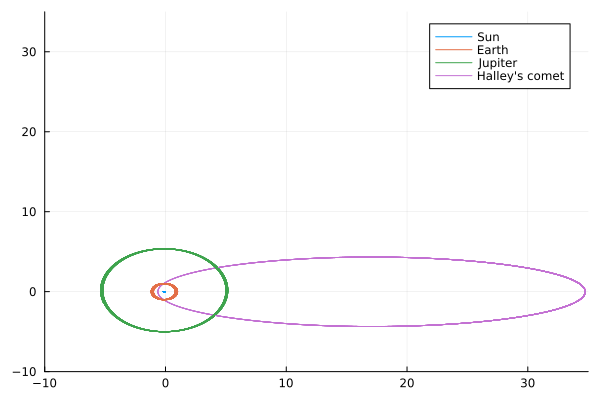

In [39]:
δt = 0.015
t_end=468

update_particles(planets, x_n)
for i in δt:δt:t_end
    x_next = 2 .* x_n .- x_old .+ accels(planets) .* δt^2
    x_old = x_n
    x_n = x_next
    update_particles(planets, x_n)
end

display(L"$x_{n+1} = 2 x_n - x_{n-1} + A(x) \delta t^2$")
display("image/png", read("./orbits.png"))
    

# NVE Molecular Dynamics Simulations
(also known as a microcanonical ensemble) 

where
* N - Number/moles of each type of atom is fixed
* V - Volume simulated is fixed
* E - (total) Energy of system is fixed 

Often classical mechanics utilized for nuclei $\rightarrow$ allows Verlet method directly for trajectories 

(The Born-Oppenheimer approximation is often used for electronic structure $\rightarrow$ machine learning techniques might be used as well in more modern approaches [paper](https://arxiv.org/pdf/2001.11696.pdf))

Similar to the gravitational example, but use electrostatic and electromagnetic potentials instead 

for example the Lennard-Jones Potential

$$U(r) = 4\varepsilon \left[\left(\frac{\sigma}{r}\right)^{12}- \left(\frac{\sigma}{r}\right)^6\right]$$

where 
$\varepsilon$ is the depth of the potential well
$\sigma$ is the distance at which the particle-particle energy is zero
$r$ is the distance between the particles

$$A(x) = -\nabla U(r) = 24\varepsilon \left[\frac{\sigma^5}{r^7} - 2\frac{\sigma^{11}}{r^{13}} \right]$$

Usually only for pair potential $\rightarrow$ need more complex potential for many systems

$1/r^{12} \rightarrow$ describes Pauli repulsion   $1/r^{6}\rightarrow$  describes the attraction/Van der Waals

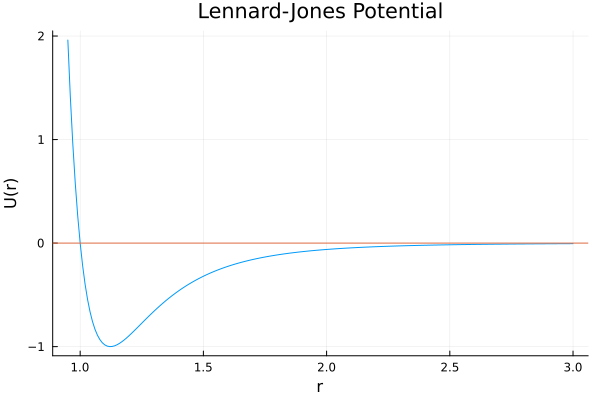

In [58]:
x=0.95:0.01:3
LJP = r -> 4 * ((1/r)^12-(1/r)^6)
plot(x, LJP.(x), title="Lennard-Jones Potential", legend=false, xlabel="r", ylabel="U(r)")
hline!([0])


In [82]:
function LJForce(a::Particle, b::Particle; ε=1, σ=1)
    r = b.position .- a.position
    rnorm = norm(r, 2)
    24*ε*(σ^5/rnorm^7 - 2*σ^11/rnorm^13) * (r/rnorm)
end

function LJAccels(plist::Vector{Particle})
    a = [zeros(size(p.position)) for p in plist]
    for i in 1:length(plist)-1
       for j in i+1:length(plist)
            f = LJForce(plist[i], plist[j])
            a[i] += f
            a[j] -= f
        end
    end
    return a
end

LJAccels (generic function with 1 method)

┌ Info: Saved animation to /home/alex/Documents/assigns/Verlet/two_body.gif
└ @ Plots /home/alex/.julia/packages/Plots/gzYVM/src/animation.jl:149


Plots.AnimatedGif("/home/alex/Documents/assigns/Verlet/two_body.gif")
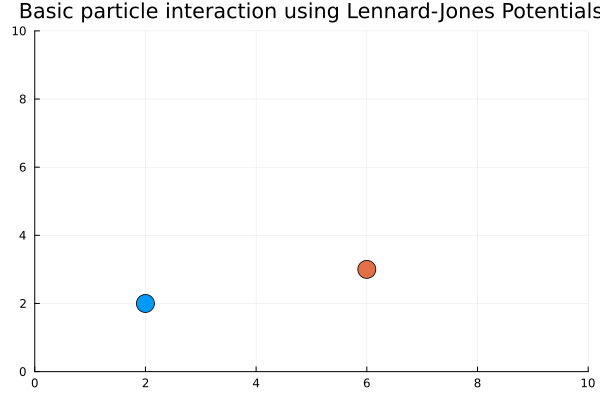

In [133]:
plot1 = plot(xlims=(0,10), ylims=(0, 10), legend=false)


p1 = Particle([2, 2], 1)
p2 = Particle([6, 3], 1)
particles = [p1, p2]

Δt = 0.01
t_end = 5
v_n = [[2, 4], [-2, 2]]

x_n  = [p1.position, p2.position]

a_positions = []
push!(a_positions, x_n)

for i in 0:Δt:t_end
    A_n    = LJAccels(particles)
    x_next    = x_n .+ v_n .* Δt .+ 0.5* A_n * Δt^2
    update_particles(particles, x_next)
    A_next = LJAccels(particles)
    v_next = v_n .+ 0.5 * (A_n + A_next) * Δt
    
    x_n = x_next
    v_n = v_next
    A_n = A_next
    push!(a_positions, x_n)
end

anim = @animate for pos ∈ a_positions
    plot(xlims=(0,10), ylims=(0, 10), legend=false, title="Basic particle interaction using Lennard-Jones Potentials")
    scatter!([pos[1][1]], [pos[1][2]], color=1, markersize=10)
    scatter!([pos[2][1]], [pos[2][2]], color=2, markersize=10)
end


gif(anim, "two_body.gif", fps = 30)

In [ ]:
# anim = @animate for pos ∈ a_positions
#     plot(xlims=(0,10), ylims=(0, 10), legend=false, title="Basic particle interaction using Lennard-Jones Potentials")
#     scatter!([pos[1][1]], [pos[1][2]], color=1, markersize=10)
#     scatter!([pos[2][1]], [pos[2][2]], color=2, markersize=10)
# end


# gif(anim, "two_body.gif", fps = 30)

## Alternative Methods for Molecular dynamics

Verlet method here uses fixed time step length, but there are methods such as the impulse or r-Respa method that can adapt time step size

## Contraints to increase stability
There are also methods to constrain/freeze high frequency modes such as the SHAKE or RATTLE method that allow for larger time step in our integration